## Models
### Split data into training, validation and testing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('data/Preprossing_data.csv')

We shuffle data

In [3]:
df_shuffle = shuffle(df, random_state=4)
df_shuffle.head(5)

,date,time,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip.,condition
573,2021-07-12,10:30 PM,81,77,89,VAR,3,0,29.79,0.0,Others
1875,2021-08-09,5:00 AM,82,79,89,SW,9,0,29.73,0.0,Others
2965,2021-08-31,11:00 PM,79,77,94,CALM,0,0,29.79,0.0,Others
2791,2021-08-28,8:00 AM,81,77,89,VAR,1,0,29.73,0.0,Others
2056,2021-08-12,11:30 PM,82,77,84,VAR,2,0,29.82,0.0,Others


Separate `condition` from data

In [4]:
y_sr = df_shuffle['condition']
X_df = df_shuffle.drop(columns='condition')

We split data into training and testing set with $80\%$, $20\%$ respectively

In [5]:
X_df, test_X_df, y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)

In [6]:
X_df.shape

(2523, 10)

In [7]:
y_sr.shape

(2523,)

In [8]:
test_X_df.shape

(631, 10)

In [9]:
test_y_sr.shape

(631,)

Let check the distribution of two set

In [10]:
y_sr.value_counts()

Others    2259
Rain       264
Name: condition, dtype: int64

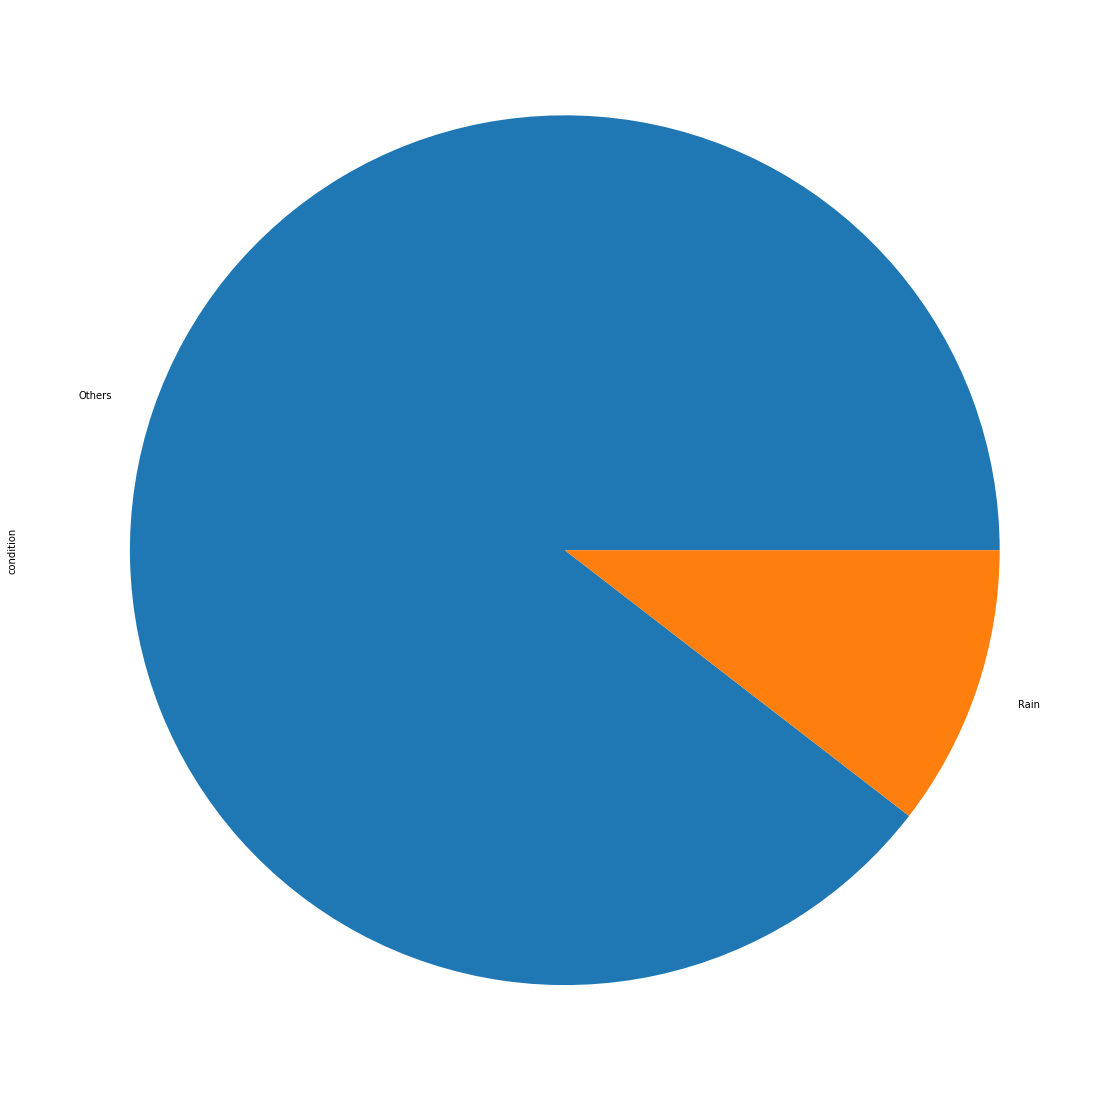

In [11]:
y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

In [12]:
test_y_sr.value_counts()

Others    572
Rain       59
Name: condition, dtype: int64

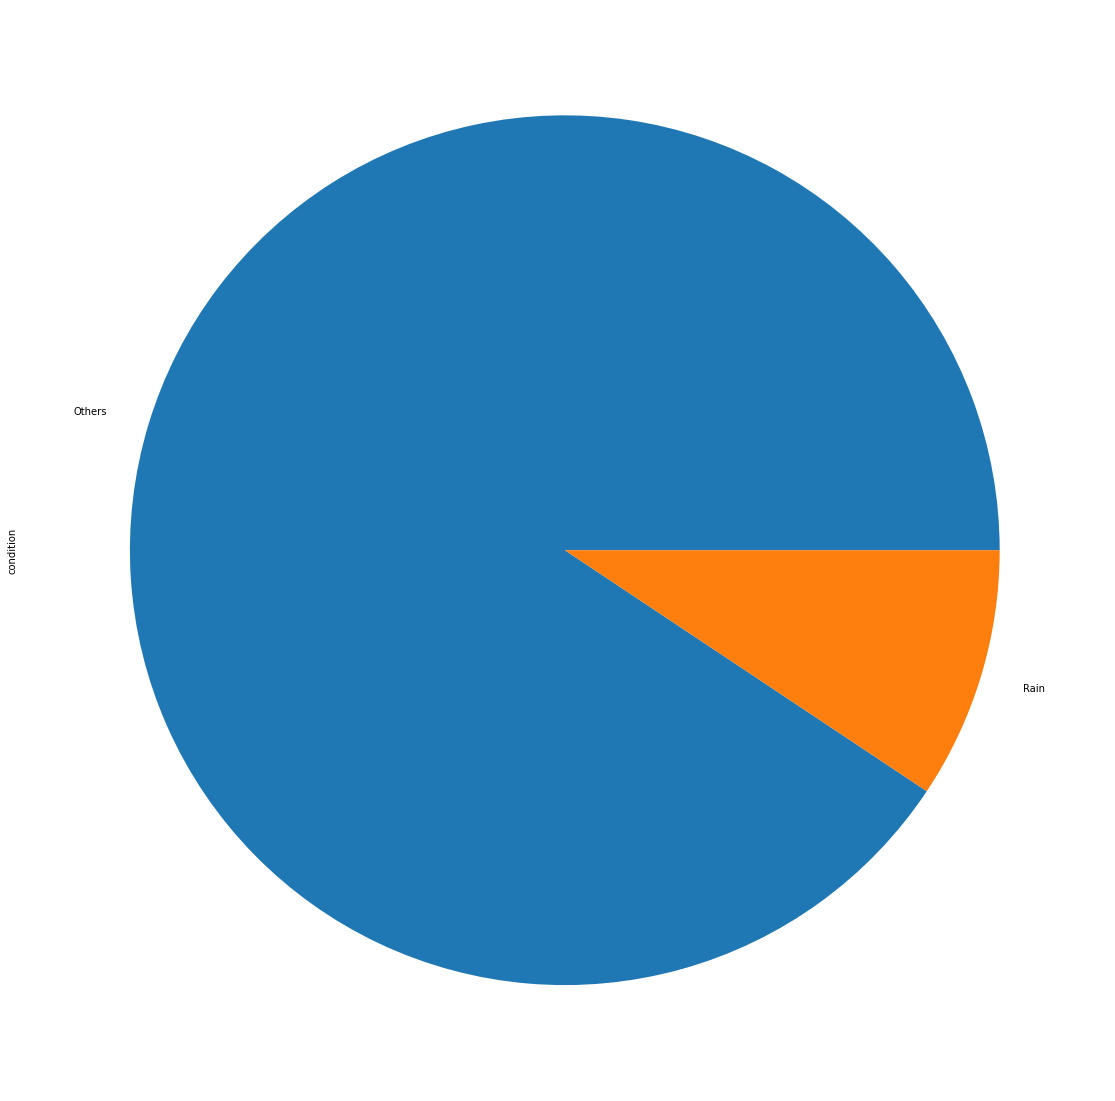

In [13]:
test_y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

The distribution of two set is approximate  
Next, we split training data into training and validation set

In [14]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.25, random_state=0)

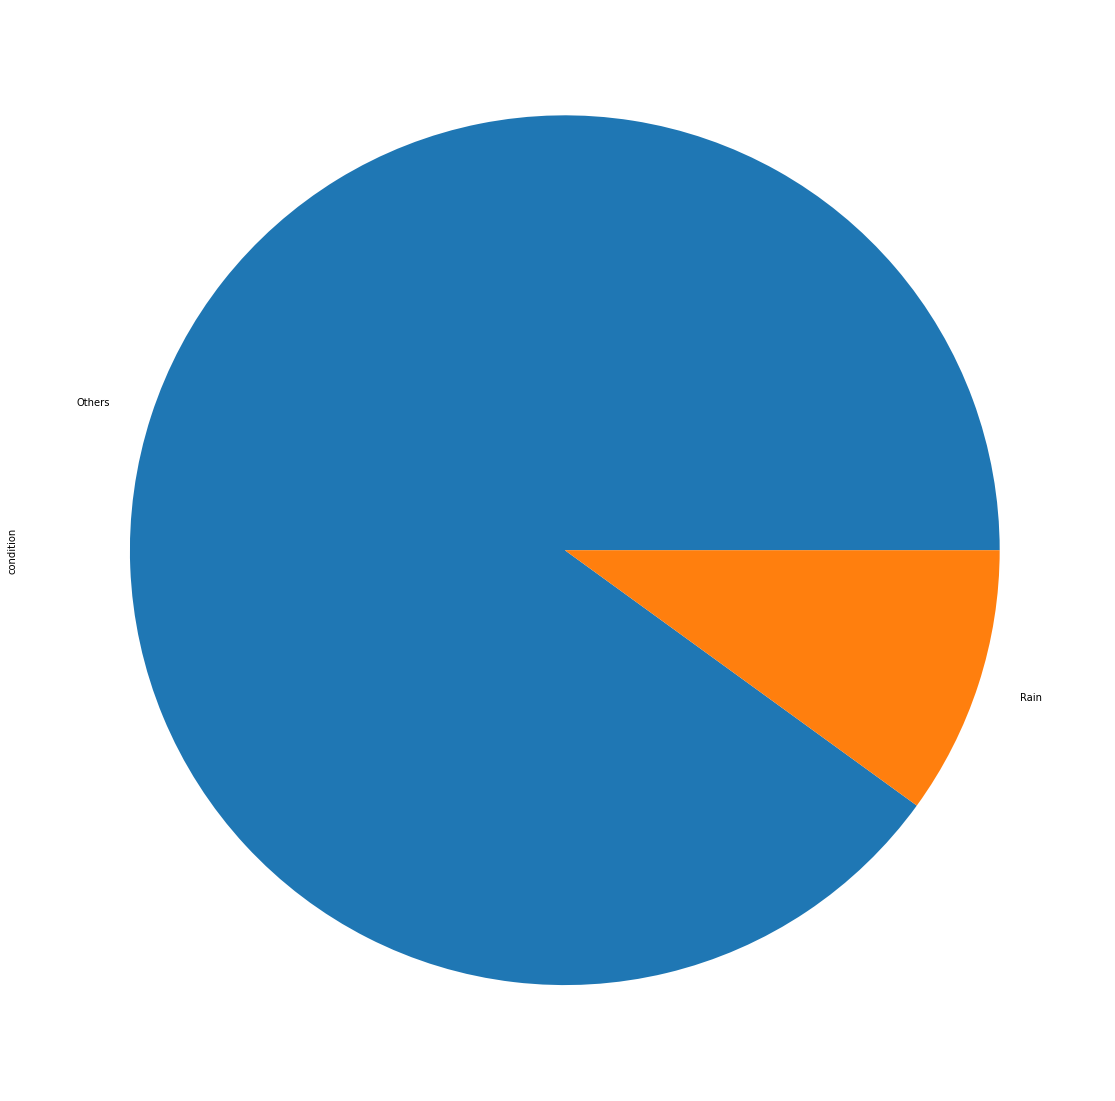

In [15]:
train_y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

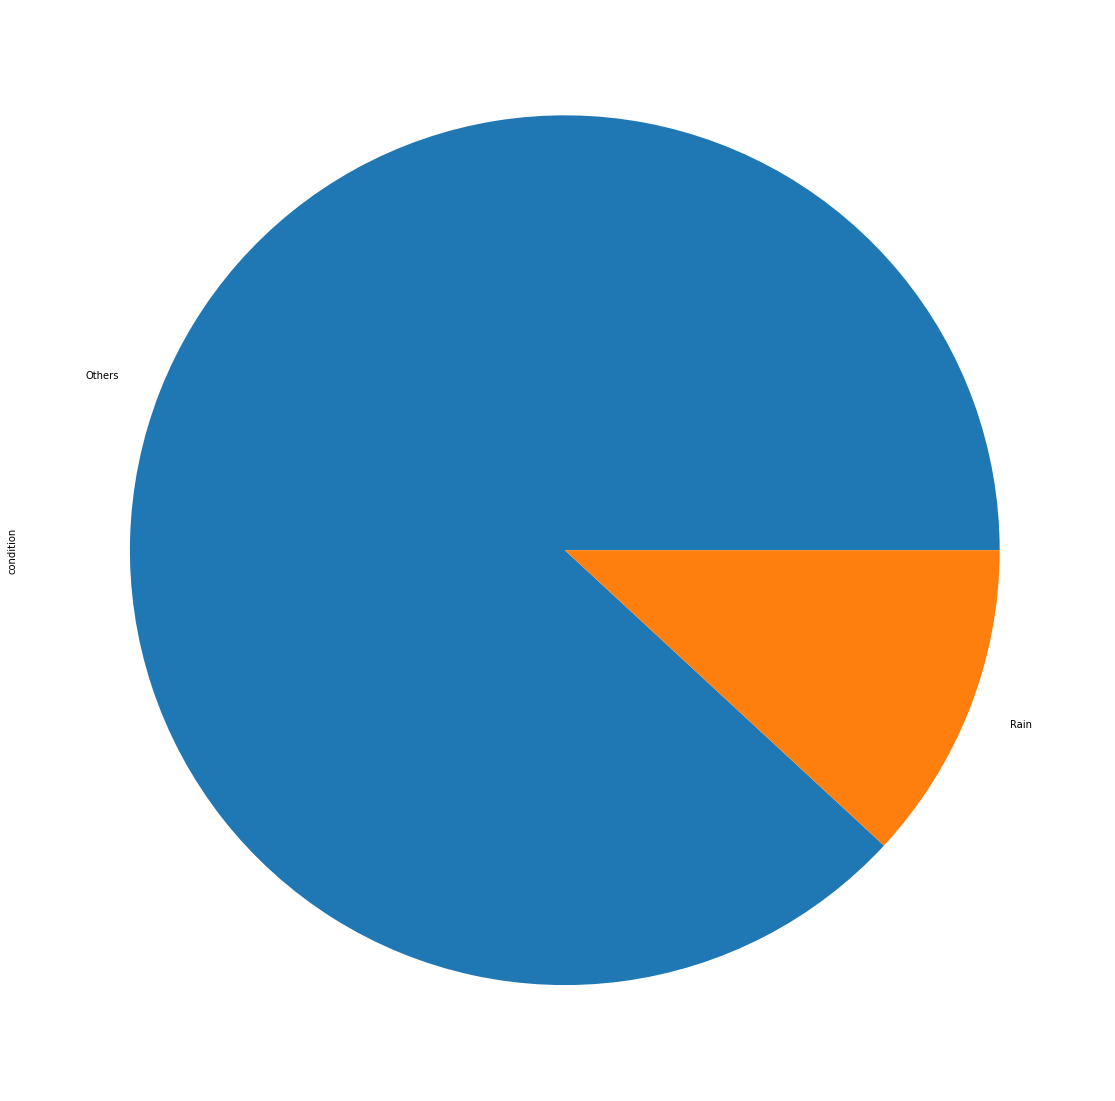

In [16]:
val_y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

Save training, validation, testing data

In [17]:
pd.concat([train_X_df, train_y_sr], axis=1).to_csv('data/training.csv', index=False)
pd.concat([val_X_df, val_y_sr], axis=1).to_csv('data/validation.csv', index=False)
pd.concat([test_X_df, test_y_sr], axis=1).to_csv('data/testing.csv', index=False)

## Preprocess data
After spliting data, we can free to preprocess data. Accroding to analysis in exploring data. There are what we will do:
* Remove `precip.`, `wind_gust` columns because it does not supply any useful information.
* Remove `date` column. The month can effect on weather, but the data we have only 3 months (July, August, September), therfore with new data, which occure in another months, model can be confused. In addition, we want to make model learning online, it means the data and model will be updated frequently, so that we think `date` column is not useful.
* With two unorder categorical columns `time` and `wind`, we use one hot encoding, in addition, because some values in wind appear very few, so that, we use a hyperparameter to keep the most frequent values.

In [3]:
train_X_df = pd.read_csv('data/training.csv')
train_y_sr = train_X_df['condition']
train_X_df.drop(columns='condition', inplace=True)

val_X_df = pd.read_csv('data/validation.csv')
val_y_sr = val_X_df['condition']
val_X_df.drop(columns='condition', inplace=True)

test_X_df = pd.read_csv('data/testing.csv')
test_y_sr = test_X_df['condition']
test_X_df.drop(columns='condition', inplace=True)

In [4]:
class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_wind=1):
        self.num_top_wind = num_top_wind
    def fit(self, X_df, y=None):
        wind_col = X_df.wind
        self.wind_counts_ = wind_col.value_counts()
        wind = list(self.wind_counts_.index)
        self.top_wind_ = wind[:max(1, min(self.num_top_wind, len(wind)))]
        return self
    def transform(self, X_df, y=None):
        temp_df = X_df.copy(deep = True)
        wind_col = temp_df.wind.str.extract(r'([A-Z]+)',expand = False)
        wind_col[~wind_col.isin(self.top_wind_)] = 'Others'
        temp_df['day_night'] =  temp_df.time.str.extract(r'([A-Z]+)')
        temp = pd.DataFrame(temp_df.time.str.split().tolist(),columns = ['t','dn'])
        temp_df['time'] = list(temp['t'])
        temp_df.drop(['precip.','date','wind_gust'], axis=1, inplace=True)
        return temp_df

Test `Preprocess` class

In [5]:
col_preprocess = Preprocess(num_top_wind=4)

In [6]:
fewer_cols_train_X_df = col_preprocess.fit_transform(train_X_df)

In [7]:
fewer_cols_train_X_df.head(5)

,time,temperature,dew_point,humidity,wind,wind_speed,pressure,day_night
0,2:30,79,75,89,VAR,2,29.73,AM
1,4:30,79,77,94,SW,5,29.70,AM
2,11:00,90,77,66,SW,12,29.70,AM
3,2:30,91,77,63,WSW,9,29.67,PM
4,2:30,79,77,94,VAR,1,29.76,AM


We will continue to preprocess following these steps:

- Numerical columns, we will fill in missing values with mean value
- Unorder categorical columns: `time` and `wind`: 
    - Convert to numerical using one-hot encoding method.
- Normalize data.

We will create a pipeline that executes these steps and also include the `Preprocess` class above.

In [5]:
num_cols = ['temperature','dew_point','humidity','wind_speed','pressure']
cate_cols = ['time','wind','day_night']

preprocess_pipeline = Pipeline(steps = [('preprocess_cate',Preprocess(num_top_wind=4)),
                                    ('imputer', ColumnTransformer(transformers=[('nume', SimpleImputer(missing_values = np.nan, strategy='mean'),num_cols),
                                        ('cate', OneHotEncoder(categories='auto', handle_unknown='ignore'), cate_cols)])),
                                   ('scale', StandardScaler(with_mean=False))])

In [56]:
preprocess_pipeline

Pipeline(steps=[('preprocess_cate', Preprocess(num_top_wind=4)),
                ('imputer',
                 ColumnTransformer(transformers=[('nume', SimpleImputer(),
                                                  ['temperature', 'dew_point',
                                                   'humidity', 'wind_speed',
                                                   'pressure']),
                                                 ('cate',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['time', 'wind',
                                                   'day_night'])])),
                ('scale', StandardScaler(with_mean=False))])

Test pipeline

In [9]:
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

In [15]:
preprocessed_train_X.shape

(1892, 49)

# Models
We will try some models and evaluate them to get a good model. There are models we will run:
* Traditional Machine Learning:
    * Linear model:
        * Logistic model
        * Linear SVM
    * Non-linear model:
        * kNN
        * Nonlinear SVM
    * Tree:
        * Decision tree
        * Random Forest
* Deep learning: Neural network

Because we focus on forcast raining weather, and in our data, raining condition is minoriy. Therefore, we use f1 score of raining class to be our metric.
Each model, we iterate hyperparameters and calculate the score on training and validation, then we choose hyparameters get the best result. The number of hyperparameters depends on models

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

## Linear models
### Logistic model
Create pipeline for logisstic model

In [7]:
logistic_model = make_pipeline(preprocess_pipeline, LogisticRegression(max_iter=500))

In [57]:
logistic_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocess_cate',
                                  Preprocess(num_top_wind=4)),
                                 ('imputer',
                                  ColumnTransformer(transformers=[('nume',
                                                                   SimpleImputer(),
                                                                   ['temperature',
                                                                    'dew_point',
                                                                    'humidity',
                                                                    'wind_speed',
                                                                    'pressure']),
                                                                  ('cate',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['time',
                                                                    'wind',
                                                                    'day_night'])])),
                                 ('scale', StandardScaler(with_mean=False))])),
                ('logisticregression', LogisticRegression(max_iter=500))])

Because most of algorithms we use have only one hyperparameter, we write function `Run_One_Hyper_Model` to train and evaluate that algorithms. The function takes `top_winds` and `model` are the parameters. `top_winds` is a list of `num_tio_wind`. The function returns traning errors, validation errors, the best validation error and the best value of hyperparameter.

In [8]:
# logistic_model.get_params().keys()
def Run_One_Hyper_Model(top_winds, model):
    train_errs = []
    val_errs = []
    best_val_err = -float('inf')
    best_num_top_wind = None
#     top_winds = [4, 6, 8, 10, 14]
    for num_top_wind in top_winds:
        model.set_params(pipeline__preprocess_cate__num_top_wind=num_top_wind)
#         print(model.get_params(pipeline__preprocess_cate__num_top_wind))
        model.fit(train_X_df, train_y_sr)
        train_preds = model.predict(train_X_df)
        train_errs.append(f1_score(train_y_sr, train_preds, pos_label = 'Rain'))
        val_preds = model.predict(val_X_df)
        val_errs.append(f1_score(val_y_sr, val_preds,  pos_label = 'Rain'))
        if val_errs[-1] > best_val_err:
            best_val_err = val_errs[-1]
            best_num_top_wind = num_top_wind
      
    return train_errs, val_errs, best_val_err, best_num_top_wind

# logistic_train_errs, logistic_val_errs, logistic_best, best_num_top_wind = Run_Linear_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], logistic_model)
# logistic_model.fit(train_X_df, train_y_sr)

`Draw_Train_Val_errs` is the function to plot training and validation errors for easlier judge model.

In [9]:
def Draw_Train_Val_errs(train_errs, val_errs, top_winds):
    plt.figure(figsize=(10, 5))
    plt.plot(top_winds, train_errs, 'o-', color = 'red')
    plt.plot(top_winds, val_errs, 'o-', color='blue')
    plt.show()
    
# Draw_Train_Val_errs(logistic_train_errs, logistic_val_errs, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

The result of logistic regression model

Best hyperparameter: 1
Best validation errors: 0.16091954022988506


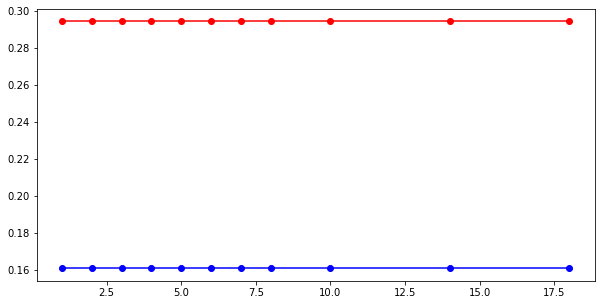

In [10]:
logistic_train_errs, logistic_val_errs, logistic_best, logistic_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], logistic_model)
print('Best hyperparameter: {0}'.format(logistic_wind))
print('Best validation errors: {0}'.format(logistic_best))
Draw_Train_Val_errs(logistic_train_errs, logistic_val_errs, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

**Comments:**
* The model is underfiting
* Feature `wind` does not effect on model

### Linear SVM


In [11]:
svm_linear = make_pipeline(preprocess_pipeline, SVC(kernel='linear', max_iter=-1))
linear_svm_train_errs, linear_svm_val_errs, linear_svm_best, linear_svm_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], svm_linear)

Best hyperparameter: 1
Best validation errors: 0.02631578947368421


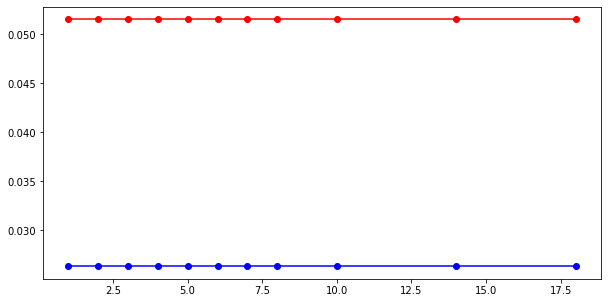

In [13]:
print('Best hyperparameter: {0}'.format(linear_svm_num_top_wind))
print('Best validation errors: {0}'.format(linear_svm_best))
Draw_Train_Val_errs(linear_svm_train_errs, linear_svm_val_errs, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

**Comment:**
* The model is underfitting
* It is even bad than logistic regression
* Feature `wind` does not effect on model

## No-linear models
### kNN model
kNN model has 2 hyperparameters, the number of neighbors and the number of top wind.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
knn_model = make_pipeline(preprocess_pipeline, KNeighborsClassifier())
n_neighbors_s = [5, 7, 9, 11, 13]
knn_train_errs, knn_val_errs, knn_best, knn_neighbors, knn_num_top_wind = [], [], -float('inf'), None, None
for n_neighbors in n_neighbors_s:
    knn_model.set_params(kneighborsclassifier__n_neighbors=n_neighbors)
    train_errs, val_errs, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], knn_model)
    knn_train_errs.append(train_errs)
    knn_val_errs.append(val_errs)
    if best_val > knn_best:
        knn_best = best_val
        knn_num_top_wind = best_para
        knn_neighbors = n_neighbors

# knn_train_errs, knn_val_errs, knn_best, knn_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], knn_model)

In [16]:
def Table_Train_Val_errs(train_errs, val_errs, index, columns, xlabel, ylabel):
    train_errs_df = pd.DataFrame(data=np.array(train_errs),
                             index=index, columns=columns)
    val_errs_df = pd.DataFrame(data=np.array(val_errs), index=index, columns=columns)
    min_err = min(np.array(train_errs).min(), np.array(val_errs).min())
    max_err = max(np.array(train_errs).max(), np.array(val_errs).max())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, 
                annot=True, cbar=False, fmt='.1f', cmap='Reds')
    plt.title('train errors'); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.subplot(1, 2, 2)
    sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, 
                annot=True, cbar=False, fmt='.1f', cmap='Reds')
    plt.title('validation errors'); plt.xlabel(xlabel); plt.ylabel(ylabel);

Best num_top_wind: 4
Best neighbors: 5
Best validation errors: 0.05


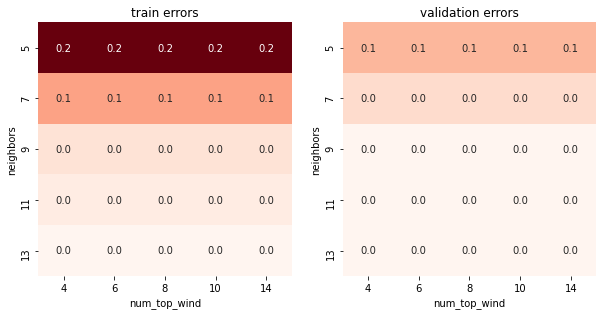

In [17]:
print('Best num_top_wind: {0}'.format(knn_num_top_wind))
print('Best neighbors: {0}'.format(knn_neighbors))
print('Best validation errors: {0}'.format(knn_best))
Table_Train_Val_errs(knn_train_errs, knn_val_errs, [5, 7, 9, 11, 13], [4, 6, 8, 10, 14], 'num_top_wind', 'neighbors')

**Comment:**
* The model is underfitting
* It is even bad than linear models
* Feature `wind` does not effect on model
* As low hyperparameter `neighbors`, as good model is

### Nonlinear SVM
#### Kernel: Poly
We use kernel poly. The model has 2 hyperparameters, the degreeses of poly and the number of top wind.

In [18]:
svm_nonlinear = make_pipeline(preprocess_pipeline, SVC(kernel = 'poly', max_iter=-1))
degreeses = [2, 3, 4]
svm_nonlinear_train_errs, svm_nonlinear_val_errs, svm_nonlinear_best, svm_nonlinear_degrees, svm_nonlinear_num_top_wind = [], [], -float('inf'), None, None
for degrees in degreeses:
    svm_nonlinear.set_params(svc__degree=degrees)
    train_errs, val_errs, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], svm_nonlinear)
    svm_nonlinear_train_errs.append(train_errs)
    svm_nonlinear_val_errs.append(val_errs)
    if best_val > svm_nonlinear_best:
        svm_nonlinear_best = best_val
        svm_nonlinear_num_top_wind = best_para
        svm_nonlinear_degrees = degrees

# svm_nonlinear = make_pipeline(preprocess_pipeline, SVC(kernel = 'poly', max_iter=-1))
# svm_nonlinear_train_errs, svm_nonlinear_val_errs, svm_nonlinear_best, svm_nonlinear_num_top_wind = Run_Linear_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], svm_nonlinear)

Best num_top_wind: 4
Best degrees: 2
Best validation errors: 0.0


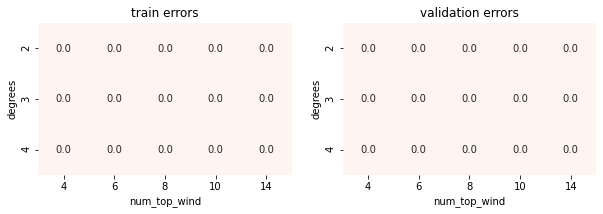

In [19]:
print('Best num_top_wind: {0}'.format(svm_nonlinear_num_top_wind))
print('Best degrees: {0}'.format(svm_nonlinear_degrees))
print('Best validation errors: {0}'.format(svm_nonlinear_best))
Table_Train_Val_errs(svm_nonlinear_train_errs, svm_nonlinear_val_errs, [2, 3, 4], [4, 6, 8, 10, 14], 'num_top_wind', 'degrees')

**Comment:**
* The model is underfitting
* It is the worst
* Feature `wind` does not effect on model

## Tree
### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
tree_model = make_pipeline(preprocess_pipeline, DecisionTreeClassifier())
tree_train_errs, tree_val_errs, tree_best, tree_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], tree_model)

Best num_top_wind: 18
Best validation errors: 0.352


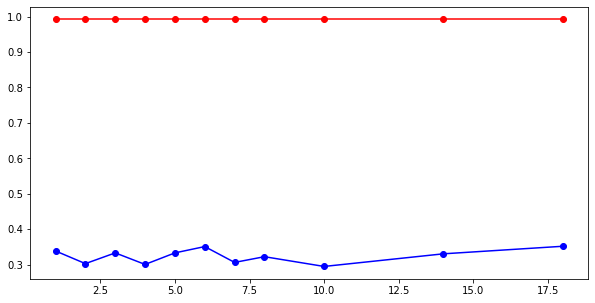

In [22]:
print('Best num_top_wind: {0}'.format(tree_num_top_wind))
print('Best validation errors: {0}'.format(tree_best))
Draw_Train_Val_errs(tree_train_errs, tree_val_errs, [1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18])

**Comment:**
* The model is very overfitting, the score is high on training set but low in on validation
* It has the best perfrom from now
* We do know why the best `num_top_wind` is 18

### Random forest
This model has 2 hyperparameters. The first is `max_depth`, we use it to prevent overfitting. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
trees_model = make_pipeline(preprocess_pipeline, RandomForestClassifier())
trees_train_errs, trees_val_errs, trees_best, trees_max_depth, trees_num_top_wind = [], [], -float('inf'), None, None
max_depths = [3, 5, 8, 10, 15]
for max_depth in max_depths:
    trees_model.set_params(randomforestclassifier__max_depth=max_depth)
    train_errs, val_errs, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], trees_model)
    trees_train_errs.append(train_errs)
    trees_val_errs.append(val_errs)
    if best_val > trees_best:
        trees_best = best_val
        trees_num_top_wind = best_para
        trees_max_depth = max_depth

# trees_train_errs, trees_val_errs, trees_best, trees_num_top_wind = Run_One_Hyper_Model([1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 18], tree_model)

Best num_top_wind: 10
Best max_depth: 15
Best validation errors: 0.25000000000000006


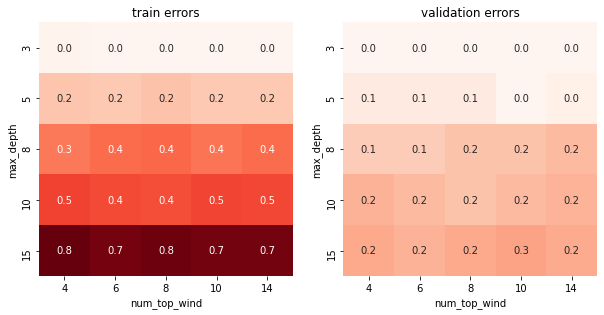

In [45]:
print('Best num_top_wind: {0}'.format(trees_num_top_wind))
print('Best max_depth: {0}'.format(trees_max_depth))
print('Best validation errors: {0}'.format(trees_best))
Table_Train_Val_errs(trees_train_errs, trees_val_errs, [3, 5, 8, 10, 15], [4, 6, 8, 10, 14], 'num_top_wind', 'max_depth')

**Comment:**
* The model is overfitting, the error is high on training set but low in on validation
* It has the best perfrom from now
* As large `max_depth` is, as overfitting model is, and as high the f1 score validation is.
* Feature `wind` seems does not effect very much

## Deep learning: Muti layer perceptron


In [46]:
from sklearn.neural_network import MLPClassifier
mlp_model = make_pipeline(preprocess_pipeline, MLPClassifier(hidden_layer_sizes = (100)))
mlp_train_errs, mlp_val_errs, mlp_best, mlp_alpha, mlp_num_top_wind = [], [], -float('inf'), None, None
alphas = [0.001, 0.01, 0.1, 1, 10]
for alpha in alphas:
    mlp_model.set_params(mlpclassifier__alpha=alpha)
    train_errs, val_errs, best_val, best_para = Run_One_Hyper_Model([4, 6, 8, 10, 14], mlp_model)
    mlp_train_errs.append(train_errs)
    mlp_val_errs.append(val_errs)
    if best_val > mlp_best:
        mlp_best = best_val
        mlp_num_top_wind = best_para
        mlp_alpha = alpha

Best num_top_wind: 10
Best alpha: 0.1
Best validation errors: 0.1680672268907563


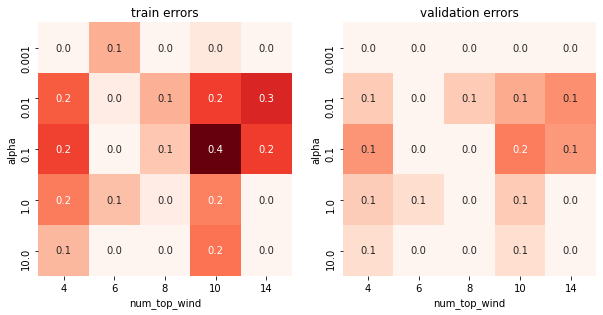

In [48]:
print('Best num_top_wind: {0}'.format(mlp_num_top_wind))
print('Best alpha: {0}'.format(mlp_alpha))
print('Best validation errors: {0}'.format(mlp_best))
Table_Train_Val_errs(mlp_train_errs, mlp_val_errs, [0.001, 0.01, 0.1, 1, 10], [4, 6, 8, 10, 14], 'num_top_wind', 'alpha')

**Comments:**
* 

## Observation:
* Simple models such as linear models haev better results than more complex models, like SVM, kNN.
* As more onverfitting models (decision tree, random forest)
## Explain
* Because our data is skew to much, so that, the complex models (such as SVM, kNN) try to fit the dominated class than the minority class, therefore, their results is low.
* The more overfitting models (decision tree, random forest) try to fit all data. Despite they fit too much but at least they try to fit, therefore, their results is quite better.
## Conclusion
So the main reason, that makes our algorithms is too week, is the unblance data and the data is not enough. We have some idea to fix it:
* Collect more data
* Oversample data
* Use more proper algorithms